In [3]:
import numpy as np
import pandas as pd
from bayes_opt import BayesianOptimization
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [4]:
df = pd.read_excel('data/All Data combined.xlsx')

In [3]:
df = df.drop(['Unnamed: 0'], axis=1)
df = df.drop(['Unnamed: 8'], axis=1)
df = df.drop(['type_of_opt'], axis=1)
df.dropna()

,number of trials,number of parameters,type of function,accuracy [calc. max/ actual max],time per trial [s],assigned_class
0,16.0,2.0,Trig,0.732417,0.009824,0.0
1,13.0,2.0,Trig,0.983980,0.008316,0.0
2,10.0,2.0,Trig,0.638160,0.007854,0.0
3,18.0,2.0,Trig,0.952784,0.009196,0.0
4,11.0,2.0,Trig,0.284646,0.007938,0.0
...,...,...,...,...,...,...
1245,9.0,2.0,linear,1.000000,0.052639,3.0
1246,10.0,2.0,linear,1.000000,0.006312,3.0
1247,7.0,2.0,linear,1.000000,0.037169,3.0
1248,17.0,2.0,linear,1.000000,0.116375,3.0


In [4]:
df = df[df['accuracy [calc. max/ actual max]'] < 1.05]  

In [5]:
x = df[['number of trials','number of parameters','accuracy [calc. max/ actual max]', 'time per trial [s]']].values

In [6]:
y = df['assigned_class']

In [7]:
df.describe()

,number of trials,number of parameters,accuracy [calc. max/ actual max],time per trial [s],assigned_class
count,1249.000000,1249.000000,1249.000000,1249.000000,1249.000000
mean,10.842274,3.039231,0.502171,0.018106,1.561249
std,4.441205,0.999630,0.360821,0.019479,1.134244
min,1.000000,2.000000,0.000000,0.003163,0.000000
25%,8.000000,2.000000,0.161572,0.007464,1.000000
50%,11.000000,4.000000,0.469765,0.010050,2.000000
75%,14.000000,4.000000,0.870366,0.019677,3.000000
max,25.000000,4.000000,1.000000,0.136035,3.000000


In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.30)

In [9]:
x_train = StandardScaler().fit(x_train).transform(x_train)
x_test = StandardScaler().fit(x_test).transform(x_test)
x_train = MinMaxScaler().fit(x_train).transform(x_train)
x_test = MinMaxScaler().fit(x_test).transform(x_test)

In [10]:
y_train = np.asarray(y_train)

In [11]:
x_train.shape

(874, 4)

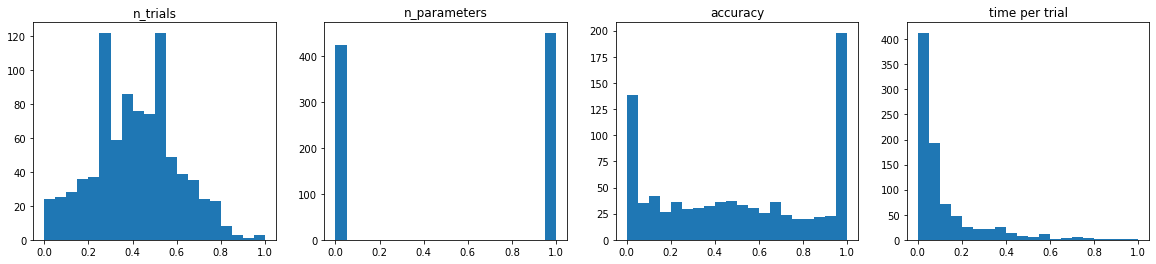

In [12]:
fig, ax = plt.subplots(figsize=(20,4), ncols = 4)
ax[0].hist(x_train[:,0], bins = 20)
ax[0].set_title('n_trials')
ax[1].hist(x_train[:,1], bins = 20)
ax[1].set_title('n_parameters')
ax[2].hist(x_train[:,2], bins = 20)
ax[2].set_title('accuracy')
ax[3].hist(x_train[:,3], bins = 20)
ax[3].set_title('time per trial')
plt.show()


## Using a Decision Tree Classifier 

In [13]:
def func(x,y):
    estimator = DecisionTreeClassifier(max_depth= int(np.round(x)))
    clf = BaggingClassifier(base_estimator=estimator, n_estimators= int(np.round(y)))
    clf = clf.fit(x_train, y_train)
    yhat = clf.predict(x_test)
    MSE = mean_squared_error(y_test, yhat)
    acc = accuracy_score(y_test, yhat)
    
    return  acc



xmin = 1
xmax = 50
ymin = 1
ymax = 50

pbounds = {'x': (xmin, xmax), 'y': (ymin, ymax)}

optimizer = BayesianOptimization(f=func, pbounds=pbounds, verbose=3)

optimizer.maximize(init_points = 20, n_iter = 30)
    
best_params = optimizer.max["params"]
    
found_x = best_params['x']
found_y = best_params['y']

max_value = func(found_x, found_y)
    
print("Found x: {}, f: {}".format(found_x, (func(found_x, found_y))))
print("Found y: {}, f: {}".format(found_y, (func(found_x, found_y))))
print("Max value found is: {}".format(max_value))

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  1        |  0.6187   |  35.68    |  18.12    |
|  2        |  0.632    |  24.06    |  33.98    |
|  3        |  0.6187   |  20.74    |  48.99    |
|  4        |  0.6213   |  16.96    |  36.45    |
|  5        |  0.6027   |  35.32    |  3.252    |
|  6        |  0.624    |  38.28    |  23.82    |
|  7        |  0.6053   |  37.85    |  4.58     |
|  8        |  0.616    |  21.77    |  20.74    |
|  9        |  0.6213   |  18.86    |  21.28    |
|  10       |  0.632    |  47.22    |  41.05    |
|  11       |  0.6213   |  47.88    |  25.51    |
|  12       |  0.6453   |  6.566    |  26.95    |
|  13       |  0.64     |  47.35    |  47.03    |
|  14       |  0.6      |  47.05    |  9.368    |
|  15       |  0.616    |  11.74    |  21.08    |
|  16       |  0.6133   |  18.51    |  21.04    |
|  17       |  0.6267   |  38.67    |  31.37    |
|  18       |  0.6133   |  45.24    |  25.57    |


In [16]:
estimator = DecisionTreeClassifier(max_depth=int(np.round(found_x)))
clf = BaggingClassifier(base_estimator=estimator, n_estimators= int(np.round(found_y)))
clf = clf.fit(x_train, y_train)
yhat = clf.predict(x_test)
MSE = mean_squared_error(y_test, yhat)
acc = accuracy_score(y_test, yhat)

In [17]:
acc

0.6213333333333333

In [18]:
x = np.array([1,0,0.4,0]).reshape(1,-1)
x

array([[1. , 0. , 0.4, 0. ]])

In [19]:
a = clf.predict(x)

In [36]:
category = int(a[0])
if category == 1
    

## Using a Random Forest Classifier 

In [26]:
def func(x,y):
    rfr = RandomForestClassifier(max_depth = int(np.round(x)), n_estimators = int(np.round(y)), max_features = 4)
    rfr = rfr.fit(x_train, y_train.flatten())
    yhat = rfr.predict(x_test)
    MSE = mean_squared_error(y_test, yhat)
    acc = accuracy_score(y_test, yhat)
    return  acc

from bayes_opt import BayesianOptimization

xmin = 1
xmax = 100
ymin = 1
ymax = 100

pbounds = {'x': (xmin, xmax), 'y': (ymin, ymax)}

optimizer = BayesianOptimization(f=func, pbounds=pbounds, verbose=4)

optimizer.maximize(init_points = 20, n_iter = 30)
    
best_params = optimizer.max["params"]
    
found_x = best_params['x']
found_y = best_params['y']

max_value = func(found_x, found_y)
    
print("Found x: {}, f: {}".format(found_x, (func(found_x, found_y))))
print("Found y: {}, f: {}".format(found_y, (func(found_x, found_y))))
print("Max value found is: {}".format(max_value))

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  1        |  0.6107   |  56.41    |  27.0     |
|  2        |  0.6      |  46.75    |  73.54    |
|  3        |  0.616    |  45.85    |  72.22    |
|  4        |  0.616    |  88.8     |  18.67    |
|  5        |  0.6133   |  82.33    |  50.7     |
|  6        |  0.6133   |  31.1     |  16.86    |
|  7        |  0.624    |  88.93    |  70.15    |
|  8        |  0.616    |  20.38    |  50.99    |
|  9        |  0.624    |  45.92    |  98.64    |
|  10       |  0.616    |  4.87     |  44.46    |
|  11       |  0.6187   |  59.37    |  22.72    |
|  12       |  0.6053   |  28.69    |  21.88    |
|  13       |  0.5973   |  46.71    |  90.05    |
|  14       |  0.6213   |  27.28    |  96.84    |
|  15       |  0.6053   |  71.48    |  58.2     |
|  16       |  0.6267   |  30.83    |  22.86    |
|  17       |  0.6107   |  23.06    |  29.78    |
|  18       |  0.6027   |  23.39    |  25.05    |


In [27]:
rfr = RandomForestClassifier(max_depth = int(np.round(found_x)), n_estimators = int(np.round(found_y)), max_features = 4)
rfr = rfr.fit(x_train, y_train.flatten())
yhat = rfr.predict(x_test)
MSE = mean_squared_error(y_test, yhat)
acc = accuracy_score(y_test, yhat)

In [29]:
acc

0.6293333333333333

## Using a Gradient Boosting Classifier 

def func(x,y):
    gbr = GradientBoostingClassifier(n_estimators = int(np.round(x)), max_depth = int(np.round(y)), learning_rate = 0.1)
    gbr = gbr.fit(x_train, y_train.flatten())
    yhat = gbr.predict(x_test)
    MSE = mean_squared_error(y_test, yhat)
    acc = accuracy_score(y_test, yhat)
    
    return  acc

xmin = 1
xmax = 50
ymin = 1
ymax = 50

pbounds = {'x': (xmin, xmax), 'y': (ymin, ymax)}

optimizer = BayesianOptimization(f=func, pbounds=pbounds, verbose=3)

optimizer.maximize(init_points = 20, n_iter = 30)
    
best_params = optimizer.max["params"]
    
found_x = best_params['x']
found_y = best_params['y']

max_value = func(found_x, found_y)
    
print("Found x: {}, f: {}".format(found_x, (func(found_x, found_y))))
print("Found y: {}, f: {}".format(found_y, (func(found_x, found_y))))
print("Max value found is: {}".format(max_value))

gbr = GradientBoostingClassifier(n_estimators = int(np.round(found_x)), max_depth = int(np.round(found_y)), learning_rate = 0.1)
gbr = gbr.fit(x_train, y_train.flatten())
yhat = gbr.predict(x_test)
MSE = mean_squared_error(y_test, yhat)
acc = accuracy_score(y_test, yhat)

## Visualizing the Data

This code will run the predictions from the Ensemble method to generate predictions based on the number of trials, accuracy, and time of iteration

In [22]:
def generate_data(b):
    n = 11 #Number of points per dimension. Number of trials = n^3
    prediction_list = []
    prediction_parameters = []
    for k in range(n):
        for j in range(n):
            for i in range(n):
                a = k/(n-1)
                c = j/(n-1)
                d = i/(n-1)
                predict_array = np.array([a,b,c,d]).reshape(1,-1)
                prediction = clf.predict(predict_array)
                prediction_parameters.append([a,c,d])
                prediction_list.append(prediction)

    p_class = np.asarray(prediction_list)
    p_parameters = np.asarray(prediction_parameters)
    data = np.hstack((p_parameters, p_class))
    return data 

In [23]:
def plot_data(data, view_angle_h, view_angle_v):
    cols = ['Trials', 'Accuracy', 'Time', 'Class']
    df = pd.DataFrame(data, columns = cols)
    
    class_0_data = np.asarray(df[df['Class'] == 0.])
    class_1_data = np.asarray(df[df['Class'] == 1.])
    class_2_data = np.asarray(df[df['Class'] == 2.])
    class_3_data = np.asarray(df[df['Class'] == 3.])
    
    plt.close()
    fig = plt.subplots(figsize=(15,10))
    ax = plt.axes(projection='3d')
    
    xline_0 = class_0_data[:,0]
    yline_0 = class_0_data[:,1]
    zline_0 = class_0_data[:,2]
    ax.scatter3D(xline_0, yline_0, zline_0, color = 'b', marker='o', s=300, alpha = 0.25, label = 'CmaEs')

    xline_1 = class_1_data[:,0]
    yline_1 = class_1_data[:,1]
    zline_1 = class_1_data[:,2]
    ax.scatter3D(xline_1, yline_1, zline_1, color = 'y', marker='o', s=300, alpha = 0.25, label = 'Random')

    xline_2 = class_2_data[:,0]
    yline_2 = class_2_data[:,1]
    zline_2 = class_2_data[:,2]
    ax.scatter3D(xline_2, yline_2, zline_2, color = 'g', marker='o', s =300, alpha = 0.25, label = 'TPE')

    xline_3 = class_3_data[:,0]
    yline_3 = class_3_data[:,1]
    zline_3 = class_3_data[:,2]
    ax.scatter3D(xline_3, yline_3, zline_3, color = 'r', marker='o', s=300, alpha = 0.25, label = 'Bayes')


    plt.legend(loc = 'upper right')
    ax.set_xlabel('Number of Trials')
    ax.set_ylabel('Accuracy')
    ax.set_zlabel('Time per Iteration')
    ax.view_init(elev= view_angle_v, azim=view_angle_h)
    plt.show()

In [24]:
data_0 = generate_data(0)
data_1 = generate_data(1)

In [25]:
%matplotlib inline 
def update(Rotate_View_h=0, Rotate_View_v=0, N_of_Params=0):
    if N_of_Params == 0:
        plot_data(data_0, Rotate_View_h, Rotate_View_v)
    else:
        plot_data(data_1, Rotate_View_h, Rotate_View_v)
interact(update, Rotate_View_h = (40,360,20), Rotate_View_v = (10,360,20), N_of_Params = (0,1,1))

interactive(children=(IntSlider(value=40, description='Rotate_View_h', max=360, min=40, step=20), IntSlider(va…

<function __main__.update(Rotate_View_h=0, Rotate_View_v=0, N_of_Params=0)>

## Importing from python file

In [1]:
from ensemble_methods import decision_tree_classifier

In [2]:
decision_tree_classifier(1,1,1,1)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  1        |  0.6373   |  38.72    |  20.01    |
|  2        |  0.6373   |  12.35    |  19.79    |
|  3        |  0.6453   |  20.32    |  41.13    |
|  4        |  0.6373   |  15.39    |  15.38    |
|  5        |  0.584    |  5.209    |  12.31    |
|  6        |  0.64     |  36.58    |  12.46    |
|  7        |  0.648    |  27.65    |  46.55    |
|  8        |  0.6267   |  17.44    |  12.37    |
|  9        |  0.6427   |  29.87    |  13.75    |
|  10       |  0.6533   |  43.78    |  39.97    |
|  11       |  0.64     |  27.19    |  32.74    |
|  12       |  0.648    |  48.29    |  40.94    |
|  13       |  0.6453   |  35.69    |  28.48    |
|  14       |  0.6373   |  30.0     |  22.34    |
|  15       |  0.5893   |  27.73    |  2.305    |
|  16       |  0.6427   |  48.44    |  32.52    |
|  17       |  0.656    |  23.12    |  33.67    |
|  18       |  0.6453   |  35.38    |  26.8     |


'TPE'